In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Project - C147/project/

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1-ZqOst-RT6vlWrAPZPiqbkETxbuIXYY1/Project - C147/project


In [ ]:
import numpy as np
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")
y_train_valid -= 769
y_test -= 769

## Data Prep

In [ ]:
def train_data_prep(X,y,sub_sample,average,noise):

    total_X = None
    total_y = None

    # Maxpooling the data (sample,22,1000) -> (sample,22,1000/sub_sample) - resultant vec has 400 points - downsampling; performing low pass filtering on EEG signals
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)

    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)

    # Averaging + noise
    #first: mean pooling - downsampling method; smoothing
    #second: add Gaussian noise; regularizing effect
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)

    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)

    # Subsampling + noise addition

    for i in range(sub_sample):

        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)

        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))


    print('Shape of X after subsampling and concatenating:',total_X.shape)
    print('Shape of Y:',total_y.shape)
    return total_X,total_y


def test_data_prep(X):

    total_X = None

    # Maxpooling the data (sample,22,1000) -> (sample,22,1000/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, 10), axis=3)


    total_X = X_max
    print('Shape of X after maxpooling:',total_X.shape)

    return total_X

In [ ]:
#Proper splitting

from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
# # Train Val split
# x_train, x_val, y_train, y_val = train_test_split(X_train_valid, y_train_valid, test_size=0.2, random_state=42)
ind_valid = np.random.choice(2115, 235, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(x_train, x_valid) = X_train_valid[ind_train], X_train_valid[ind_valid]
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]

x_train,y_train = train_data_prep(x_train,y_train,10,10,True)
x_valid,y_valid = train_data_prep(x_valid,y_valid,10,10,True)
print("Val prep shape=",x_valid.shape)
x_test = test_data_prep(X_test)

# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test, 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_valid.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)

# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)

Shape of X after maxpooling: (1880, 22, 100)
Shape of X after averaging+noise and concatenating: (3760, 22, 100)
Shape of X after subsampling and concatenating: (22560, 22, 100)
Shape of Y: (22560,)
Shape of X after maxpooling: (235, 22, 100)
Shape of X after averaging+noise and concatenating: (470, 22, 100)
Shape of X after subsampling and concatenating: (2820, 22, 100)
Shape of Y: (2820,)
Val prep shape= (2820, 22, 100)
Shape of X after maxpooling: (443, 22, 100)
Shape of training labels after categorical conversion: (22560, 4)
Shape of validation labels after categorical conversion: (2820, 4)
Shape of test labels after categorical conversion: (443, 4)
Shape of training set after adding width info: (22560, 22, 100, 1)
Shape of validation set after adding width info: (2820, 22, 100, 1)
Shape of test set after adding width info: (443, 22, 100, 1)
Shape of training set after dimension reshaping: (22560, 100, 1, 22)
Shape of validation set after dimension reshaping: (2820, 100, 1, 22)
Sh

## Model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F

class TransformerEncoder(nn.Module):
    def __init__(self, input_dim, num_heads, dim_feedforward, dropout=0.1):
        super(TransformerEncoder, self).__init__()
        self.attention = nn.MultiheadAttention(input_dim, num_heads, dropout=dropout)
        self.feed_forward = nn.Sequential(
            nn.Linear(input_dim, dim_feedforward),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim_feedforward, input_dim)
        )
        self.norm1 = nn.LayerNorm(input_dim)
        self.norm2 = nn.LayerNorm(input_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        residual = x
        x = self.norm1(x) # layernorm
        x, _ = self.attention(x, x, x) # attention
        x = self.dropout(x)
        x = x + residual # ResNet actiation
        residual = x
        x = self.norm2(x)
        x = self.feed_forward(x)
        x = self.dropout(x)
        x = x + residual
        return x

In [ ]:
class HybridCNNTransformer(nn.Module):
    def __init__(self):
        super(HybridCNNTransformer, self).__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=100, out_channels=200, kernel_size=(5, 5), padding=(2, 2)),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=(3, 1), padding=(1, 0)),
            nn.BatchNorm2d(200),
            nn.Dropout(0.6)
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=200, out_channels=100, kernel_size=(5, 5), padding=(2, 2)),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=(3, 1), padding=(1, 0)),
            nn.BatchNorm2d(100),
            nn.Dropout(0.6)
        )
        self.transformer = TransformerEncoder(input_dim=100, num_heads=4, dim_feedforward=512, dropout=0.5)
        self.fc = nn.Linear(100, 4)

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        batch_size, time_steps, _, channels = x.shape
        x = x.view(batch_size, channels, time_steps)
        x = self.transformer(x)
        x = x.mean(dim=1)  # Take the mean across the time dimension
        x = self.fc(x)
        return torch.softmax(x, dim=1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HybridCNNTransformer().to(device)

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

# Convert NumPy arrays to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
x_valid_tensor = torch.tensor(x_valid, dtype=torch.float32).to(device)
y_valid_tensor = torch.tensor(y_valid, dtype=torch.float32).to(device)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

# Create datasets and data loaders
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(x_valid_tensor, y_valid_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

## Training Loop

In [ ]:
criterion = nn.CrossEntropyLoss()
learning_rate = 1e-3
l2_reg = 1e-5
hybrid_cnn_transformer_optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2_reg)

epochs = 20
training_losses = []
val_losses = []
training_accs = []
val_accs = []
for epoch in range(epochs):
    model.train()
    total_train = 0
    correct_train = 0
    total_train_loss = 0.0
    for inputs, labels in train_loader:
        hybrid_cnn_transformer_optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        hybrid_cnn_transformer_optimizer.step()
        total_train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        one_hot_tensor = F.one_hot(predicted, num_classes=4)
        correct_train += (one_hot_tensor == labels).all(dim=1).sum().item()

    average_train_loss = total_train_loss / len(train_loader.dataset)
    training_losses.append(average_train_loss)
    train_accuracy = correct_train / total_train
    training_accs.append(train_accuracy)
    # Validation loop
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        total_val_loss = 0.0
        for inputs, labels in valid_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            one_hot_tensor = F.one_hot(predicted, num_classes=4)
            correct += (one_hot_tensor == labels).all(dim=1).sum().item()
            total_val_loss += loss.item() * inputs.size(0)

    valid_accuracy = correct / total
    average_val_loss = total_val_loss / len(valid_loader.dataset)
    val_losses.append(average_val_loss)
    val_accs.append(valid_accuracy)
    print(f'Epoch {epoch+1}/{epochs}, '
          f'Train Loss: {average_train_loss:.4f}, '
          f'Val Loss: {average_val_loss:.4f}, '
          f'Train Accuracy: {train_accuracy:.4f}, '
          f'Val Accuracy: {valid_accuracy:.4f}')

Epoch 1/20, Train Loss: 1.2831, Val Loss: 1.2577, Train Accuracy: 0.4312, Val Accuracy: 0.3376
Epoch 2/20, Train Loss: 1.1496, Val Loss: 1.1426, Train Accuracy: 0.5832, Val Accuracy: 0.3713
Epoch 3/20, Train Loss: 1.0898, Val Loss: 1.0868, Train Accuracy: 0.6457, Val Accuracy: 0.3656
Epoch 4/20, Train Loss: 1.0573, Val Loss: 0.9800, Train Accuracy: 0.6785, Val Accuracy: 0.3606
Epoch 5/20, Train Loss: 1.0236, Val Loss: 0.9426, Train Accuracy: 0.7145, Val Accuracy: 0.4004
Epoch 6/20, Train Loss: 1.0021, Val Loss: 1.0895, Train Accuracy: 0.7346, Val Accuracy: 0.3780
Epoch 7/20, Train Loss: 0.9907, Val Loss: 0.9688, Train Accuracy: 0.7492, Val Accuracy: 0.3851
Epoch 8/20, Train Loss: 0.9729, Val Loss: 1.1043, Train Accuracy: 0.7663, Val Accuracy: 0.3897
Epoch 9/20, Train Loss: 0.9673, Val Loss: 0.9381, Train Accuracy: 0.7722, Val Accuracy: 0.3887
Epoch 10/20, Train Loss: 0.9554, Val Loss: 0.9187, Train Accuracy: 0.7844, Val Accuracy: 0.4028
Epoch 11/20, Train Loss: 0.9477, Val Loss: 0.8907

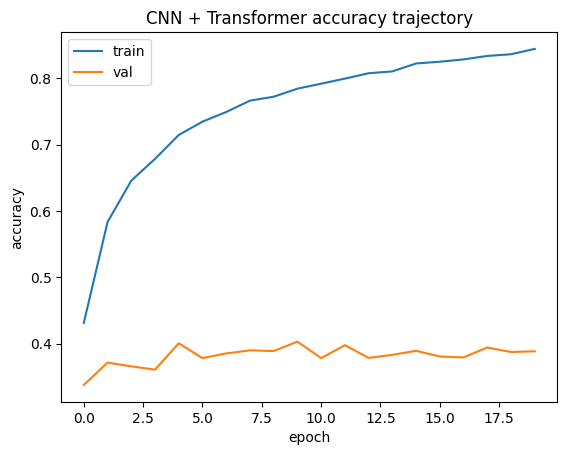

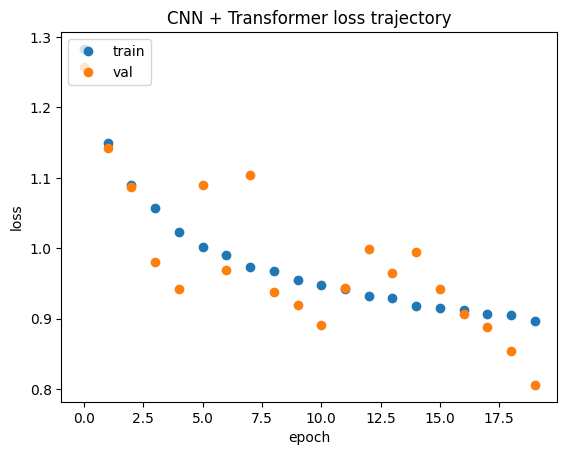

In [ ]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(training_accs)
plt.plot(val_accs)
plt.title('CNN + Transformer accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(training_losses,'o')
plt.plot(val_losses,'o')
plt.title('CNN + Transformer loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Evaluation loop on test set
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        one_hot_tensor = F.one_hot(predicted, num_classes=4)
        correct += (one_hot_tensor == labels).all(dim=1).sum().item()

test_accuracy = correct / total
print('Test accuracy of the hybrid CNN+Transformer model:', test_accuracy)

Test accuracy of the hybrid CNN+Transformer model: 0.40857787810383744
